# Sentiment Analysis for Financial News - Modelling

In [6]:
# Import packages
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import re

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot

import pandas as pd
pd.set_option('display.max_colwidth', -1)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

!pip install torch
!pip install torchtext
import torch
from torchtext import data
import torch.nn as nn

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dsxuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     |████████████████████████████████| 753.2MB 42kB/s  eta 0:00:011                             | 8.0MB 6.9MB/s eta 0:01:48     |█                               | 22.9MB 6.9MB/s eta 0:01:46     |█▎                              | 31.1MB 41.0MB/s eta 0:00:18     |█▋                              | 37.7MB 41.0MB/s eta 0:00:18     |███▏                            | 74.3MB 39.5MB/s eta 0:00:18��████▌                     | 247.4MB 10.8MB/s eta 0:00:47     |███████████▎                    | 265.8MB 10.8MB/s eta 0:00:46     |████████████▏                   | 286.7MB 16.2MB/s eta 0:00:29     |███████████████████▋            | 462.3MB 9.7MB/s eta 0:00:31     |████████████████████▎           | 476.7MB 9.7MB/s eta 0:00:29�█████████▍          | 503.3MB 5.5MB/s eta 0:00:46█████████████▏        | 544.7MB 44.8MB/s eta 0:00:05��        | 551.1MB 44.8MB/s eta 0:00:05��        | 557.9MB 44.8MB/s eta 0:00:05     |████████████████████████        | 564.7MB 38.1MB/s eta 0:00:05MB/s eta 0:00:03��██████▏    | 

## Data Processing

### Import Data

In [7]:
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# Credentials and the data retrieval from IBM Cloud Object Storage has been removed for security reasons.
client_x = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='REMOVED',
    ibm_auth_endpoint="REMOVED",
    config=Config(signature_version='oauth'),
    endpoint_url='REMOVED')

body = client_x.get_object(Bucket='REMOVED',Key='all-data.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body, encoding="ISO-8859-1", header=None)
df.columns = ["sentiment", "title"]
df.head()


,sentiment,title
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."
3,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
4,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."


### Data Cleansing

In [8]:
# Function to clean the titles
stopword_set = set(stopwords.words('english'))
forbidden_words = ["``", "''", "--", "'s"]
lemmatizer = WordNetLemmatizer() 

def lowercase(text):
    return str(text).lower()

def joinText(text):
    return " ".join(text)

def cleanText(text):
    text=lowercase(text)
    # Remove words with numbers
    text = re.sub('\w*\d\w*', '', text)
    # Tokenize
    text=word_tokenize(text)
    
    clean_text = []
    for w in text:
        if w not in stopword_set and w not in forbidden_words and w not in punctuation:
            w = lemmatizer.lemmatize(w)
            clean_text.append(w)

    clean_text=joinText(clean_text)
    return clean_text

df['title'] = df['title'].map(lambda text: cleanText(text))
df.head()


,sentiment,title
0,neutral,according gran company plan move production russia although company growing
1,neutral,technopolis plan develop stage area le square meter order host company working computer technology telecommunication statement said
2,negative,international electronic industry company elcoteq laid ten employee tallinn facility contrary earlier layoff company contracted rank office worker daily postimees reported
3,positive,new production plant company would increase capacity meet expected increase demand would improve use raw material therefore increase production profitability
4,positive,according company updated strategy year basware target long-term net sale growth range operating profit margin net sale


## Model (Linear SVM) Definition

In [9]:
sgd_classifier_model = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                            ('clf-svm', SGDClassifier(loss='log', penalty='l2', max_iter=1000, random_state=None))])

## Model Training

In [10]:
# Data shuffling and normalizing
df = shuffle(df)
df_normalized=df.groupby('sentiment').apply(lambda x: x.sample(604)).reset_index(drop=True)
print(df_normalized.shape)

# Test and validation data creation
feature1 = df_normalized["title"]
feature2 = df_normalized["sentiment"]

x_training_data, x_validation_data, y_training_data, y_validation_data = train_test_split(feature1, feature2, test_size=0.2, random_state=0)  

(1812, 2)


In [11]:
# Trainining the model and optimizing hyperparameters

parameters = {}
parameters['clf-svm__alpha'] = [0.001, 0.0005, 0.0001]

clf = GridSearchCV(sgd_classifier_model, parameters)
clf.fit(x_training_data, y_training_data)
print(clf.best_score_)    
print(clf.best_params_)    

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.



0.6459627329192547
{'clf-svm__alpha': 0.0001}


## Model Evaluation

              precision    recall  f1-score   support

    negative       0.72      0.67      0.69       127
     neutral       0.60      0.69      0.64       119
    positive       0.62      0.57      0.60       117

   micro avg       0.64      0.64      0.64       363
   macro avg       0.65      0.64      0.64       363
weighted avg       0.65      0.64      0.64       363



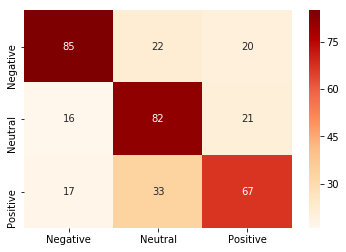

In [12]:
prediction = clf.predict(x_validation_data)
print(classification_report(y_validation_data, prediction))

df_cm = confusion_matrix(y_validation_data, prediction)
labels = ["Negative", "Neutral", "Positive"]
sns.heatmap(df_cm, annot=True,cmap="OrRd", xticklabels=labels, yticklabels=labels)

As a result, it can be seen that the most common misclassification is labelling positive titles as neutral. The accuracy was around 64 %. Next, the performance is analysed using the whole dataset.

### Comparison using the whole dataset instead of smaller, normalized one

In [13]:
# Test and validation data creation
feature1 = df["title"]
feature2 = df["sentiment"]

x_training_data, x_validation_data, y_training_data, y_validation_data = train_test_split(feature1, feature2, test_size=0.2, random_state=0) 

# Trainining the model and optimizing hyperparameters

parameters = {}
parameters['clf-svm__alpha'] = [0.001, 0.0005, 0.0001]

clf2 = GridSearchCV(sgd_classifier_model, parameters)
clf2.fit(x_training_data, y_training_data)
print(clf2.best_score_)    
print(clf2.best_params_)   

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning:

max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.



0.7438080495356038
{'clf-svm__alpha': 0.0001}


              precision    recall  f1-score   support

    negative       0.71      0.36      0.48       121
     neutral       0.71      0.92      0.80       553
    positive       0.72      0.46      0.56       296

   micro avg       0.71      0.71      0.71       970
   macro avg       0.72      0.58      0.62       970
weighted avg       0.71      0.71      0.69       970



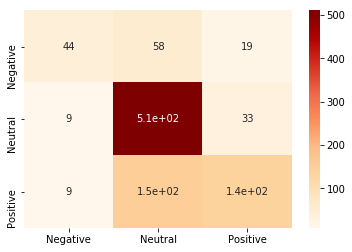

In [14]:
prediction = clf2.predict(x_validation_data)
print(classification_report(y_validation_data, prediction))

df_cm = confusion_matrix(y_validation_data, prediction)
labels = ["Negative", "Neutral", "Positive"]
sns.heatmap(df_cm, annot=True,cmap="OrRd", xticklabels=labels, yticklabels=labels)

This time the whole dataset was used without normalizing it so that each category had an equal amount of samples. As a result, the accuracy increased to 74 %. However, this caused titles with neutral sentiment to dominte the other categories, decreasing the recall of negative and positive titles. As can be seen from the confusion matrix, negative labels are very poorly detected, and also less than half of positive ones are detected correctly. As a conclusion, such model was not considered optimal for the use case, and the model with lower accuracy was chosen.

## Data processing for LSTM model

For the second model, LSTM was chosen.

In [15]:
# Split data into train and validation
df2 = df[["title","sentiment"]] 
df2.columns = ['text', 'target']
df2[['target']] = df2[['target']].replace(["positive","neutral","negative"], [2, 1, 0])
df2 = df2[df2['text'].map(len) > 10]
train_df, valid_df = train_test_split(df2, test_size=0.2)

In [16]:
# Configure
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [17]:
TEXT = data.Field(tokenize = word_tokenize, include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [18]:
# source : https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8
# to use DataFrame as a Data source

class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.target if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)
    
    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [19]:
fields = [('text',TEXT), ('label',LABEL)]

train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)

In [20]:
# Build vocabulary using GloVe
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.200d',
                 unk_init = torch.Tensor.zero_)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                               
100%|█████████▉| 399332/400000 [00:55<00:00, 7629.45it/s]

In [21]:
LABEL.build_vocab(train_ds)

## Model 2 (LSTM) Definition

This model relies heavily on the following Kaggle notebook: https://www.kaggle.com/swarnabha/pytorch-text-classification-torchtext-lstm

In [22]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [23]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

In [24]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)       
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
 
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        output = self.fc1(hidden)
        output = self.dropout(self.fc2(output))
                
        return output


In [25]:
# Create an instance of the LSTM_net class
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [26]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([7579, 200])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1189,  0.1599, -0.2332,  ...,  0.6788,  0.9448,  0.3268],
        ...,
        [ 0.1892,  0.0165,  0.5557,  ...,  0.6909, -0.2369,  0.7791],
        [-0.5785,  0.1491,  0.0510,  ...,  0.1844,  0.2903,  0.2528],
        [-0.0364, -0.4738, -0.1913,  ...,  0.4871, -0.0841,  0.5200]])

In [27]:
# Initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1189,  0.1599, -0.2332,  ...,  0.6788,  0.9448,  0.3268],
        ...,
        [ 0.1892,  0.0165,  0.5557,  ...,  0.6909, -0.2369,  0.7791],
        [-0.5785,  0.1491,  0.0510,  ...,  0.1844,  0.2903,  0.2528],
        [-0.0364, -0.4738, -0.1913,  ...,  0.4871, -0.0841,  0.5200]])


In [28]:
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

## Model 2 Training

In [30]:
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Model 2 Evaluation

In [31]:
def evaluate(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = binary_accuracy(predictions, batch.label)
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator)

100%|█████████▉| 399332/400000 [01:10<00:00, 7629.45it/s]

In [313]:
loss=[]
acc=[]
val_acc=[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

	Train Loss: -20.621 | Train Acc: 57.05%
	 Val. Acc: 64.18%
	Train Loss: -66.958 | Train Acc: 61.67%
	 Val. Acc: 60.97%
	Train Loss: -178.144 | Train Acc: 59.40%
	 Val. Acc: 60.46%
	Train Loss: -326.159 | Train Acc: 61.91%
	 Val. Acc: 62.01%
	Train Loss: -676.606 | Train Acc: 64.39%
	 Val. Acc: 63.84%
	Train Loss: -1066.460 | Train Acc: 59.48%
	 Val. Acc: 59.04%
	Train Loss: -1488.934 | Train Acc: 63.95%
	 Val. Acc: 58.31%
	Train Loss: -1678.587 | Train Acc: 64.20%
	 Val. Acc: 64.49%
	Train Loss: -2620.654 | Train Acc: 64.81%
	 Val. Acc: 40.65%
	Train Loss: -3105.650 | Train Acc: 60.74%
	 Val. Acc: 48.23%
	Train Loss: -3575.702 | Train Acc: 64.08%
	 Val. Acc: 51.69%
	Train Loss: -4368.822 | Train Acc: 62.08%
	 Val. Acc: 57.65%
	Train Loss: -5579.807 | Train Acc: 64.33%
	 Val. Acc: 60.91%
	Train Loss: -6598.165 | Train Acc: 64.11%
	 Val. Acc: 60.34%
	Train Loss: -7444.642 | Train Acc: 65.24%
	 Val. Acc: 61.73%
	Train Loss: -8431.545 | Train Acc: 65.47%
	 Val. Acc: 59.02%
	Train Loss: -1

As can be seen, the training accuracy is about 66 %, and the validation accuracy is around 63 %. Most likely there isn't any remarkable under- or overfitting. The low accuracy can be explained at least partially by the small amount of data as well as the misclassified samples that were detected previously in the initial data exploration phase. Only under 5000 data points were used for this task. It is worth noticing that while the previous SGDClassifier had a normalized dataset containing 604 titles for each category, this model was trained with all the available datapoints.

As a conclusion, due to the increased complexity, poor performance, and high computational expense, SGDClassifier was chosen as the final, deployable model.


# Deployment

In [326]:
# Save the model
from sklearn.externals import joblib 
joblib_file = "production_model_SGDClassifier.pkl"   
joblib.dump(clf, joblib_file)

['production_model_SGDClassifier.pkl']

In [321]:
!mkdir model-dir
!cp production_model_SGDClassifier.pkl model-dir
!tar -zcvf production_model_SGDClassifier.tar.gz production_model_SGDClassifier.pkl

production_model_SGDClassifier.pkl


In [336]:
import pickle
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient( {
  "apikey": "REMOVED",
  "iam_apikey_description": "REMOVED",
  "iam_apikey_name": "REMOVED",
  "iam_role_crn": "REMOVED",
  "iam_serviceid_crn": "REMOVED",
  "instance_id": "REMOVED",
  "url": "REMOVED"
} )
pipeline = joblib.load( "production_model_SGDClassifier.pkl")
model_details = client.repository.store_model( pipeline, "My scikit-learn model (in-memory object)" )

In [337]:
model_id = model_details["metadata"]["guid"]
model_deployment_details = client.deployments.create( artifact_uid=model_id, name="SVM sentiment analysis model deployment" )



#######################################################################################

Synchronous deployment creation for uid: 'e5195880-088a-478a-9f17-8183b0f4c75b' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='eb52acdb-b151-4c86-b150-845fef367084'
------------------------------------------------------------------------------------------------




## Testing API

In [341]:
model_endpoint_url = client.deployments.get_scoring_url( model_deployment_details )
model_endpoint_url

'https://us-south.ml.cloud.ibm.com/v3/wml_instances/4a4e4888-e056-4b13-b540-d8d10e4ff354/deployments/eb52acdb-b151-4c86-b150-845fef367084/online'

In [381]:
scoring_endpoint = "https://us-south.ml.cloud.ibm.com/v3/wml_instances/4a4e4888-e056-4b13-b540-d8d10e4ff354/deployments/eb52acdb-b151-4c86-b150-845fef367084/online"
payload_scoring = {'fields': ["title"], 
                   'values': [["No surprises in Apple's revenue"]]}
client.deployments.score(scoring_endpoint,payload_scoring)


{'fields': ['prediction', 'probability'],
 'values': [['neutral',
   [0.2311133110833331, 0.44926031477886685, 0.3196263741378001]]]}